In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-RACE-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20201116-RUN40-DataSheet-UMI-Constant-RACE.csv"
run = "run40-race"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run40-race-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,ID598t0-R-IgGE_S245,ATGTA,CGRGPSGVATIGGGQGTLVT,2304,16,IGHV3-53,"IGHJ4,IGHJ5,IGHJ6",5,0.002170,12.626733,1.264822
1,ID598t0-R-IgGE_S245,ATGTA,CGRDASRHHVDIVATILGYWGQGTLVT,2052,15,IGHV3-7,"IGHJ4,IGHJ5,IGHJ1",4,0.001949,11.245684,1.185771
2,ID598t0-R-IgGE_S245,ATGTA,CAKVGDDYSGSHLWSGYFDNWGQGTLVT,1584,16,IGHV3-23,IGHJ4,1570,0.991162,8.680879,1.264822
3,ID598t0-R-IgGE_S245,ATGTA,CAKDRSGNYKGYLDYWGPGTLVT,1466,12,IGHV1-46,IGHJ4,1457,0.993861,8.034197,0.948617
4,ID598t0-R-IgGE_S245,ATGTA,CARAHYYDTSDTQEAFDIWGQGTMVT,1079,9,IGHV1-2,IGHJ3,0,0.000000,5.913301,0.711462


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
12356,ID657t0-R-IgM_S252,CARRRYSYGYYYYYMDVWGKGTTVT,1009,11,1000,0.991080,5.052832,0.510441
12439,ID657t0-R-IgM_S252,CARVAKSGDYGGEYYYYYMDVWGKGTTVT,906,11,0,0.000000,4.537032,0.510441
11718,ID657t0-R-IgM_S252,CAARDYIDYVFDFWGQGTLVT,833,12,1,0.001200,4.171466,0.556845
12508,ID657t0-R-IgM_S252,CARVPSTRAATLYFDYWGQGTLVT,820,12,1626,1.982927,4.106365,0.556845
12159,ID657t0-R-IgM_S252,CARGDCTGGVCYVPHWGQGTLVT,796,18,9,0.011307,3.986179,0.835267


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,...,Species,Chain,Patient,SampleInfo,UMI,Group,HEK cells,RACE,Constant,ChainOrig
0,N721_S516,ID598t0-R-IgGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S245,...,human,BCRh,ID598t0,IgSub RACE,yes,NaN,no,yes,yes,IgGE
1,N722_S516,ID629t0-R-IgGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S246,...,human,BCRh,ID629t0,IgSub RACE,yes,NaN,no,yes,yes,IgGE
2,N723_S516,ID638t0-R-IgGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S247,...,human,BCRh,ID638t0,IgSub RACE,yes,NaN,no,yes,yes,IgGE
3,N724_S516,ID657t0-R-IgGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S248,...,human,BCRh,ID657t0,IgSub RACE,yes,NaN,no,yes,yes,IgGE
4,N726_S516,ID598t0-R-IgM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S249,...,human,BCRh,ID598t0,IgSub RACE,yes,NaN,no,yes,yes,IgM


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,ID598t0-R-IgGE_S245,ID598t0
1,ID629t0-R-IgGE_S246,ID629t0
2,ID638t0-R-IgGE_S247,ID638t0
3,ID657t0-R-IgGE_S248,ID657t0
4,ID598t0-R-IgM_S249,ID598t0


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,ID657t0-R-IgM_S252,CARRRYSYGYYYYYMDVWGKGTTVT,1009,11,1000,0.991080,5.052832,0.510441,ID657t0
1,ID657t0-R-IgM_S252,CARVAKSGDYGGEYYYYYMDVWGKGTTVT,906,11,0,0.000000,4.537032,0.510441,ID657t0
2,ID657t0-R-IgM_S252,CAARDYIDYVFDFWGQGTLVT,833,12,1,0.001200,4.171466,0.556845,ID657t0
3,ID657t0-R-IgM_S252,CARVPSTRAATLYFDYWGQGTLVT,820,12,1626,1.982927,4.106365,0.556845,ID657t0
4,ID657t0-R-IgM_S252,CARGDCTGGVCYVPHWGQGTLVT,796,18,9,0.011307,3.986179,0.835267,ID657t0


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                              ID598t0                     \
Sample                   ID598t0-R-IgGE_S245 ID598t0-R-IgM_S249   
cdr3pep                                                           
AFLEWPNNYYYYYMDVWGKGTTVT                 0.0                0.0   
AFLEWPNYYYMDVWGKGTTVT                    0.0                0.0   
AFLEWPNYYYYMDVWGKGTTVT                   0.0                0.0   
AFLEWPNYYYYYMDVWGKGTMVT                  0.0                0.0   
AFLEWPNYYYYYMDVWGKGTTVT                  0.0                0.0   

Patient                              ID629t0                     \
Sample                   ID629t0-R-IgGE_S246 ID629t0-R-IgM_S250   
cdr3pep                                                           
AFLEWPNNYYYYYMDVWGKGTTVT                 0.0                0.0   
AFLEWPNYYYMDVWGKGTTVT                    0.0                0.0   
AFLEWPNYYYYMDVWGKGTTVT                   0.0                0.0   
AFLEWPNYYYYYMDVWGKGTMVT                  0.0                0.0   
AFLEWPNYYYYYMDVWGKGTTVT                  0.0                0.0   

Patient                              ID638t0                     \
Sample                   ID638t0-R-IgGE_S247 ID638t0-R-IgM_S251   
cdr3pep                                                           
AFLEWPNNYYYYYMDVWGKGTTVT                 0.0                0.0   
AFLEWPNYYYMDVWGKGTTVT                    0.0                0.0   
AFLEWPNYYYYMDVWGKGTTVT                   0.0                0.0   
AFLEWPNYYYYYMDVWGKGTMVT                  0.0                0.0   
AFLEWPNYYYYYMDVWGKGTTVT                  0.0                0.0   

Patient                              ID657t0                     
Sample                   ID657t0-R-IgGE_S248 ID657t0-R-IgM_S252  
cdr3pep                                                          
AFLEWPNNYYYYYMDVWGKGTTVT                 1.0                0.0  
AFLEWPNYYYMDVWGKGTTVT                    1.0                0.0  
AFLEWPNYYYYMDVWGKGTTVT                   4.0                0.0  
AFLEWPNYYYYYMDVWGKGTMVT                  1.0                0.0  
AFLEWPNYYYYYMDVWGKGTTVT                151.0                0.0

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                                 ID598t0                     \
Sample                      ID598t0-R-IgGE_S245 ID598t0-R-IgM_S249   
Patient Sample                                                       
ID598t0 ID598t0-R-IgGE_S245            1.000000           0.000143   
        ID598t0-R-IgM_S249             0.000143           1.000000   
ID629t0 ID629t0-R-IgGE_S246            0.000698           0.000000   
        ID629t0-R-IgM_S250             0.000098           0.000173   
ID638t0 ID638t0-R-IgGE_S247            0.000342           0.000000   

Patient                                 ID629t0                     \
Sample                      ID629t0-R-IgGE_S246 ID629t0-R-IgM_S250   
Patient Sample                                                       
ID598t0 ID598t0-R-IgGE_S245            0.000698           0.000098   
        ID598t0-R-IgM_S249             0.000000           0.000173   
ID629t0 ID629t0-R-IgGE_S246            1.000000           0.000200   
        ID629t0-R-IgM_S250             0.000200           1.000000   
ID638t0 ID638t0-R-IgGE_S247            0.000311           0.000000   

Patient                                 ID638t0                     \
Sample                      ID638t0-R-IgGE_S247 ID638t0-R-IgM_S251   
Patient Sample                                                       
ID598t0 ID598t0-R-IgGE_S245            0.000342           0.000000   
        ID598t0-R-IgM_S249             0.000000           0.000083   
ID629t0 ID629t0-R-IgGE_S246            0.000311           0.000192   
        ID629t0-R-IgM_S250             0.000000           0.000128   
ID638t0 ID638t0-R-IgGE_S247            1.000000           0.000057   

Patient                                 ID657t0                     
Sample                      ID657t0-R-IgGE_S248 ID657t0-R-IgM_S252  
Patient Sample                                                      
ID598t0 ID598t0-R-IgGE_S245            0.000126           0.000052  
        ID598t0-R-IgM_S249             0.000024           0.000137  
ID629t0 ID629t0-R-IgGE_S246            0.000946           0.000210  
        ID629t0-R-IgM_S250             0.000120           0.000047  
ID638t0 ID638t0-R-IgGE_S247            0.000111           0.000000

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run40-race-similarity-IGH_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 2.352221673374011e-05
max value: 1.0
Wrote run40-race-similarity-IGH_HUMAN.pdf to disk


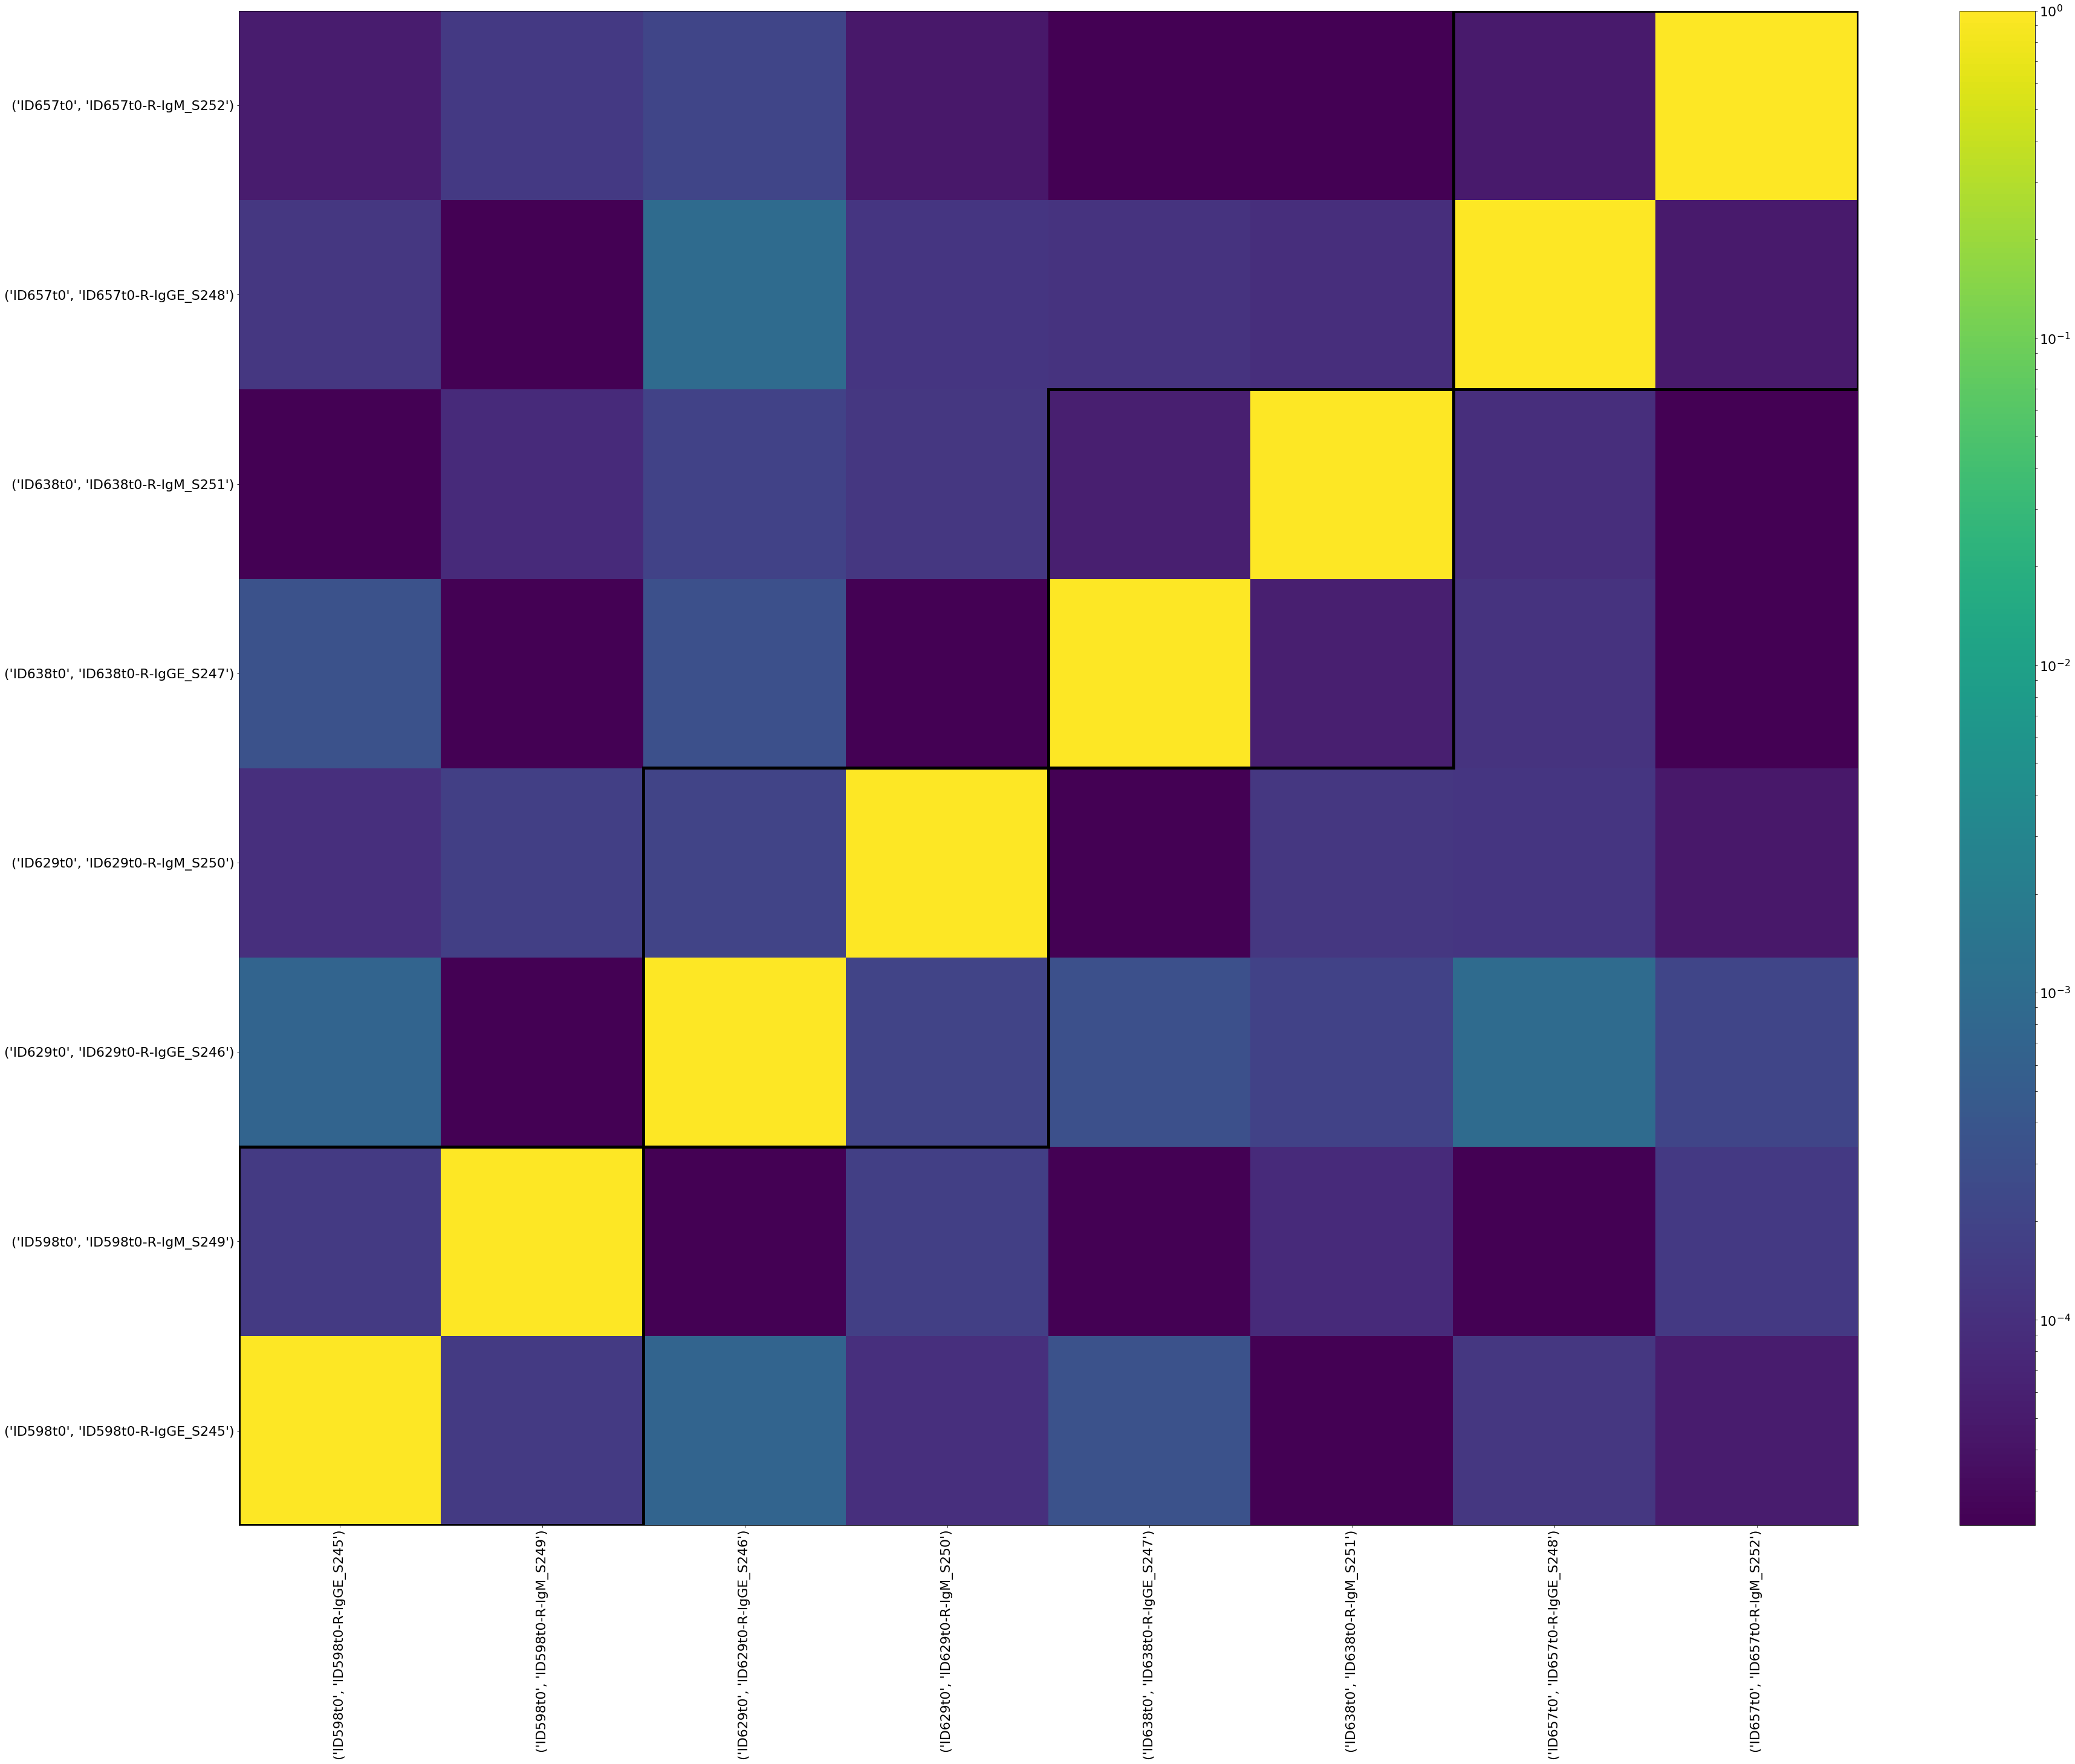

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.0001120418170836579 6.255680293906123e-05
mean diff patient 0.00016800009109953218 0.00021800678328793842
threshold 0.0010400272242512857


{'whiskers': [<matplotlib.lines.Line2D at 0x7f73ae3514a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f73ae351d68>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f73ae351358>,
 'medians': [<matplotlib.lines.Line2D at 0x7f73abcb75f8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f73abcb7a20>,
 'means': []}

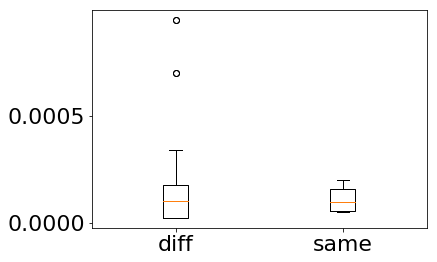

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

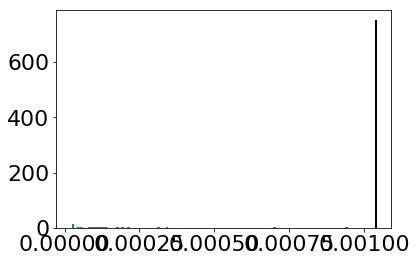

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

Wrote run40-race-similarity-IGH_HUMAN.txt to disk


In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 2.352221673374011e-05
max value: 1.0
Wrote run40-race-similarity-IGH_HUMAN-highlighted.pdf to disk


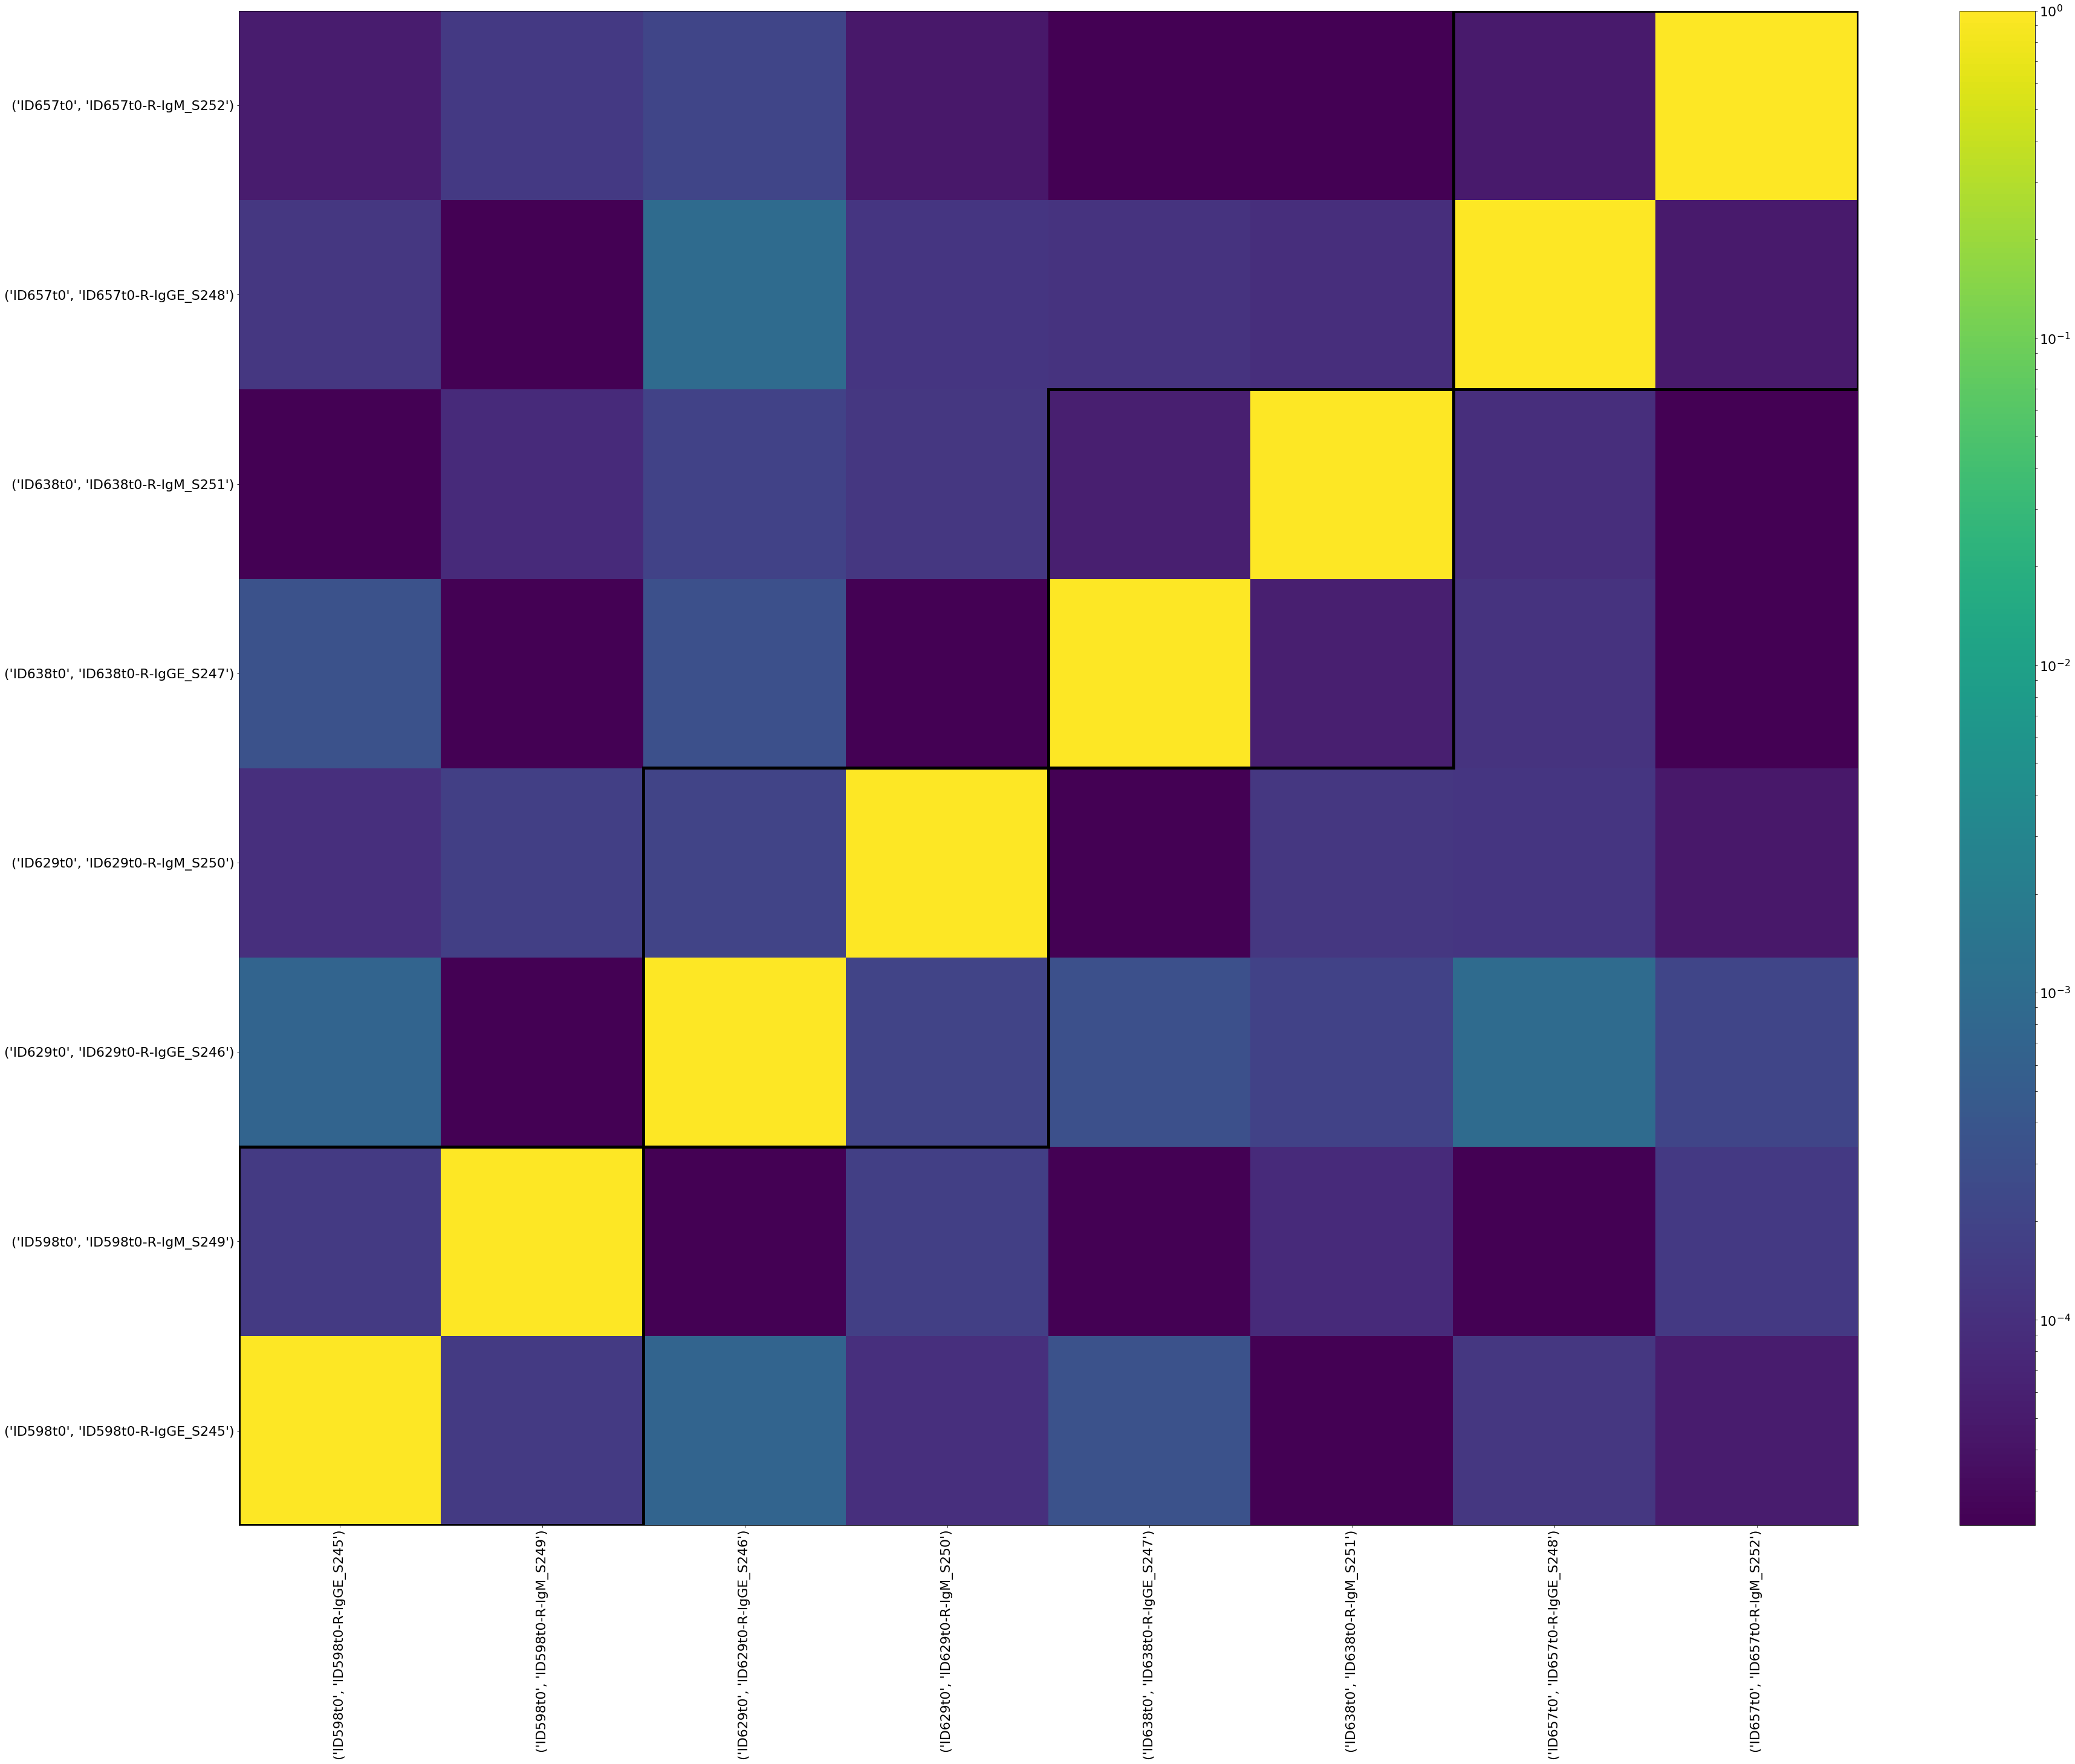

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)